# Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [12]:
SEED = 42
np.random.seed(SEED)

# Load Data

In [2]:
# Data folder path
data_dir = Path().parent / "data"
data_dir.mkdir(exist_ok=True)

In [3]:
# Read data files
target_col = 'Listening_Time_minutes'

train = pd.read_csv(data_dir / 'train.csv')
X, y = train.drop(columns=[target_col]), train[target_col]

test = pd.read_csv(data_dir / 'test.csv')
sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')

In [8]:
X.shape

(750000, 11)

In [9]:
for col in X.columns:
    missing_values = X[col].isna().sum()
    if missing_values > 0:
        # Print the number of missing values
        print(f"Column: {col} has {missing_values} missing values")

Column: Episode_Length_minutes has 87093 missing values
Column: Guest_Popularity_percentage has 146030 missing values
Column: Number_of_Ads has 1 missing values


# EDA

## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split

RATIO = 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=RATIO, 
    stratify=train[target_col],
    random_state=SEED)


## Target Distribution

----------------------------------------
Stats:
----------------------------------------
Train Mean: 45.43906178961666
Train Std: 27.13859359937977
----------------------------------------
Validation Mean: 45.4307842822
Validation Std: 27.137244161427407


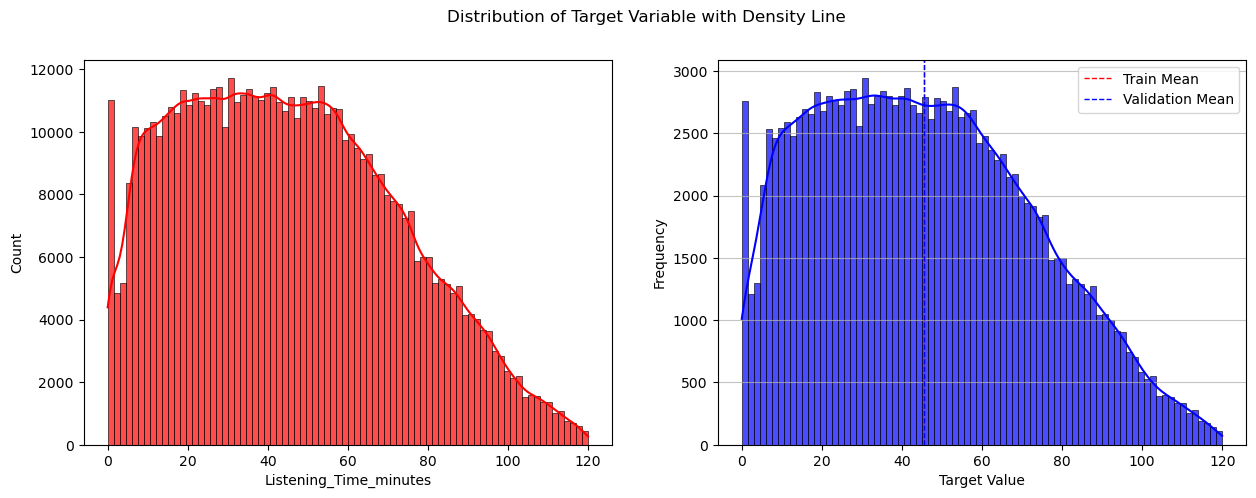

In [42]:
# Simple plotting of the target variable

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_train, bins=80, kde=True, color='red', alpha=0.7, ax=ax[0])
plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=1, label='Train Mean')

# Quick peak at the validation set
sns.histplot(y_val, bins=80, kde=True, color='blue', alpha=0.7, ax=ax[1])
plt.axvline(y_val.mean(), color='blue', linestyle='dashed', linewidth=1, label='Validation Mean')

fig.suptitle('Distribution of Target Variable with Density Line')

plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()


print("--"*20)
print(f"Stats:")
print("--"*20)
print(f"Train Mean: {y_train.mean()}")
print(f"Train Std: {y_train.std()}")
print("--"*20)
print(f"Validation Mean: {y_val.mean()}")
print(f"Validation Std: {y_val.std()}")

## Mean Target value vs features

Exploring correlation between target value and the rest of the columns

In [19]:
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

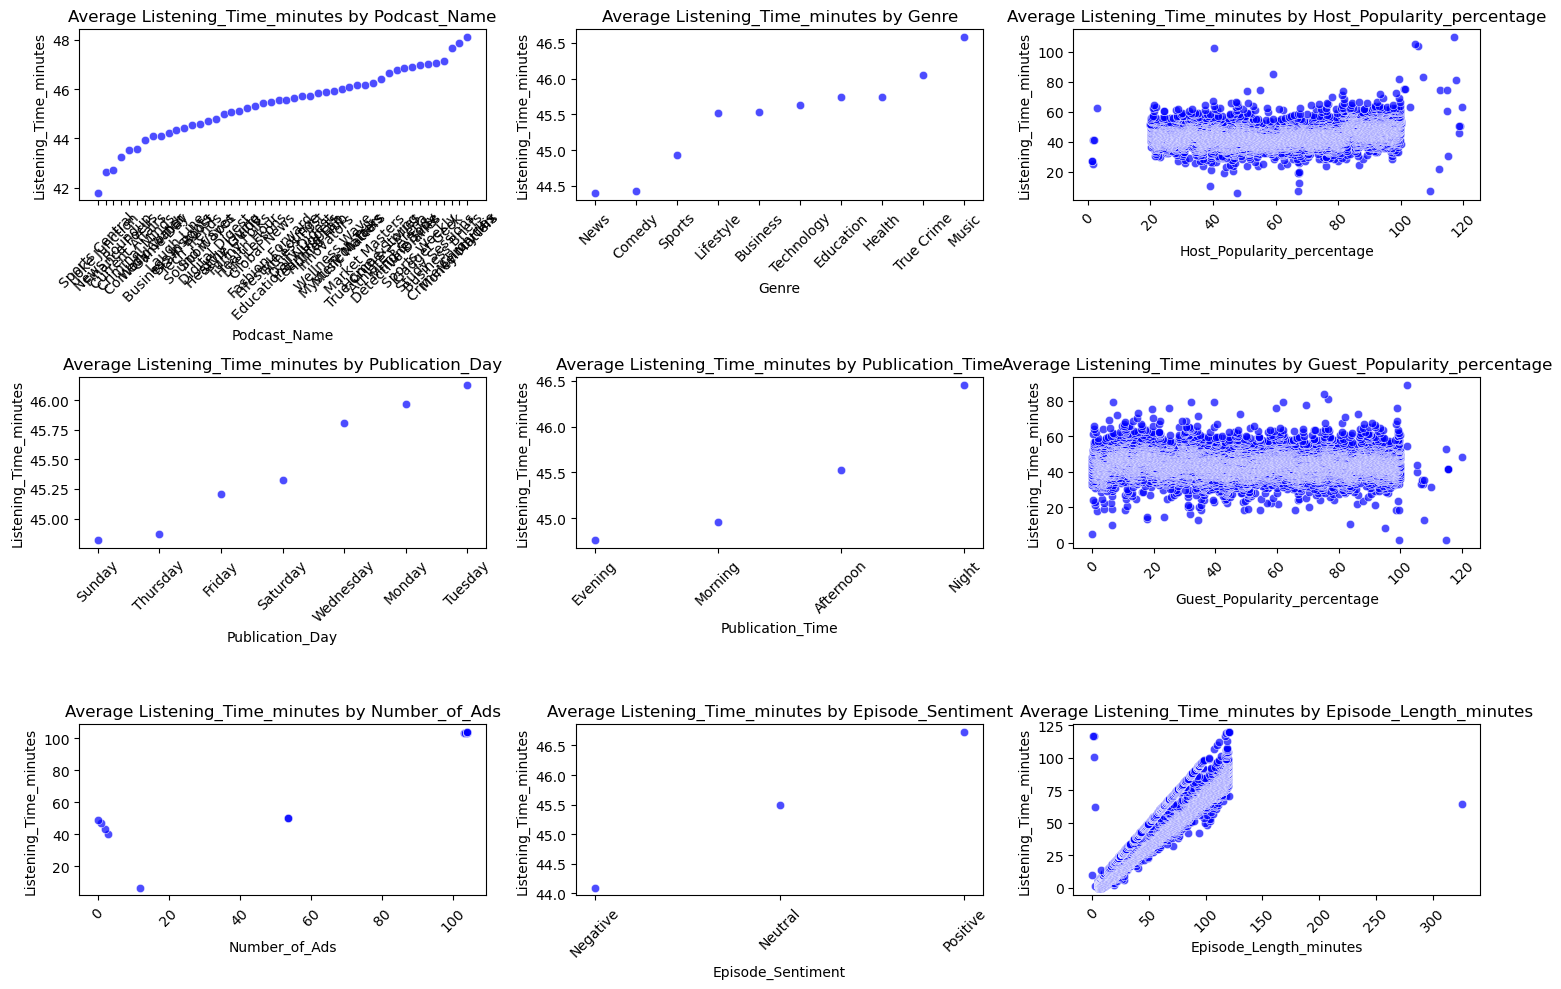

In [95]:
avg_target_per_category = ['Podcast_Name', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Episode_Length_minutes']

ordinal_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

cat_ordinal_order = {}

# Plot average target value per category
plt.figure(figsize=(15, 10))
for i, col in enumerate(avg_target_per_category):
    grouped = train.groupby(col)[target_col].mean().sort_values().reset_index()
    if col in ordinal_cols:
        # Create a mapping for ordinal categories
        cat_ordinal_order[col] = {val: idx for idx, val in enumerate(grouped[col])}
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=grouped, x=col, y=target_col, color='blue', alpha=0.7)
    plt.title(f'Average {target_col} by {col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45)
    plt.tight_layout()

In [96]:
cat_ordinal_order

{'Podcast_Name': {'Sports Central': 0,
  'Joke Junction': 1,
  'News Roundup': 2,
  'Finance Focus': 3,
  'Current Affairs': 4,
  'Criminal Minds': 5,
  'Comedy Corner': 6,
  'World Watch': 7,
  'Game Day': 8,
  'Business Insights': 9,
  'Laugh Line': 10,
  'Brain Boost': 11,
  'Tech Trends': 12,
  'Sound Waves': 13,
  'Sport Spot': 14,
  'Digital Digest': 15,
  'Healthy Living': 16,
  'Style Guide': 17,
  'Funny Folks': 18,
  'Health Hour': 19,
  'Life Lessons': 20,
  'Global News': 21,
  'Fashion Forward': 22,
  'Lifestyle Lounge': 23,
  'Educational Nuggets': 24,
  'Fitness First': 25,
  'Daily Digest': 26,
  'Learning Lab': 27,
  'Humor Hub': 28,
  'Innovators': 29,
  'Wellness Wave': 30,
  'Mystery Matters': 31,
  'Music Matters': 32,
  'Tech Talks': 33,
  'Market Masters': 34,
  'True Crime Stories': 35,
  'Home & Living': 36,
  "Athlete's Arena": 37,
  'Detective Diaries': 38,
  'Mind & Body': 39,
  'Tune Time': 40,
  'Sports Weekly': 41,
  'Gadget Geek': 42,
  'Study Sessions':

## Features Distribution

### Train set

In [52]:
def plot_features_distribution(df, cols):
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], bins=80, kde=True, color='blue', alpha=0.7)
        plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.legend()
        plt.show()

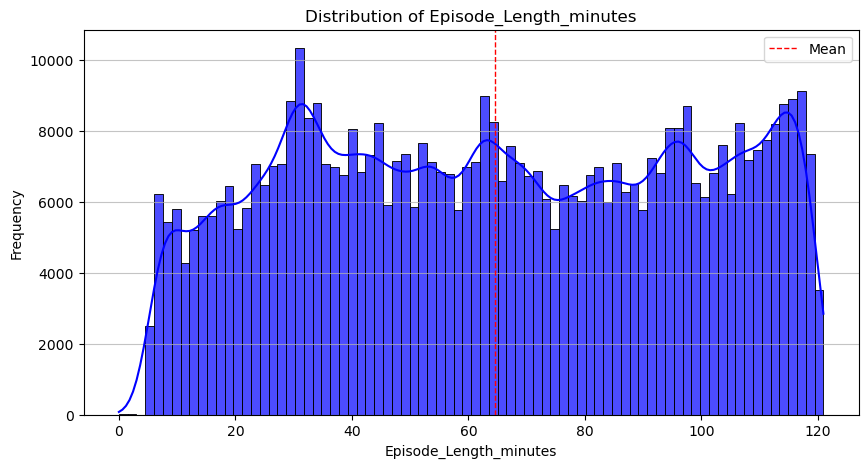

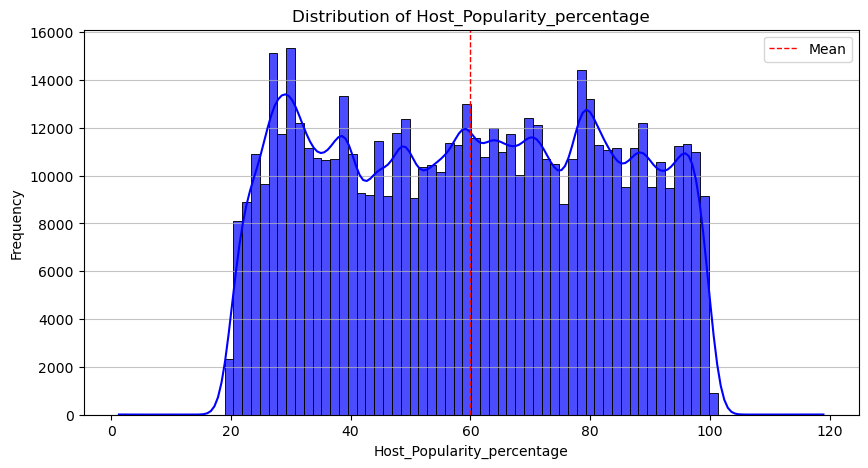

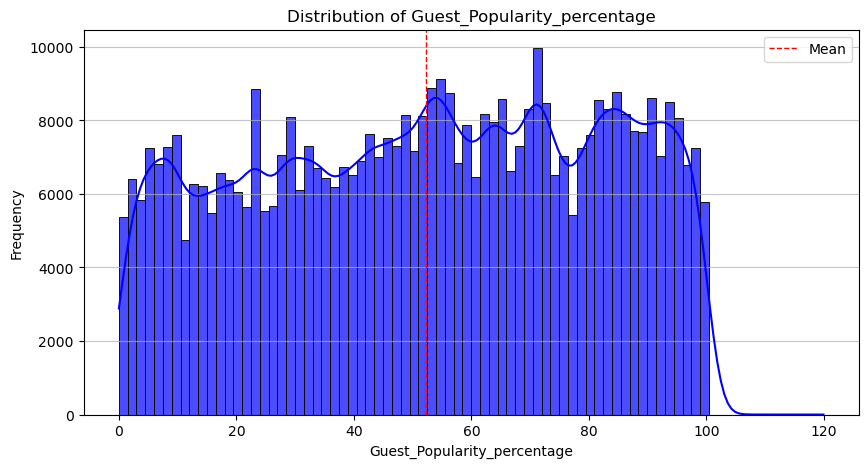

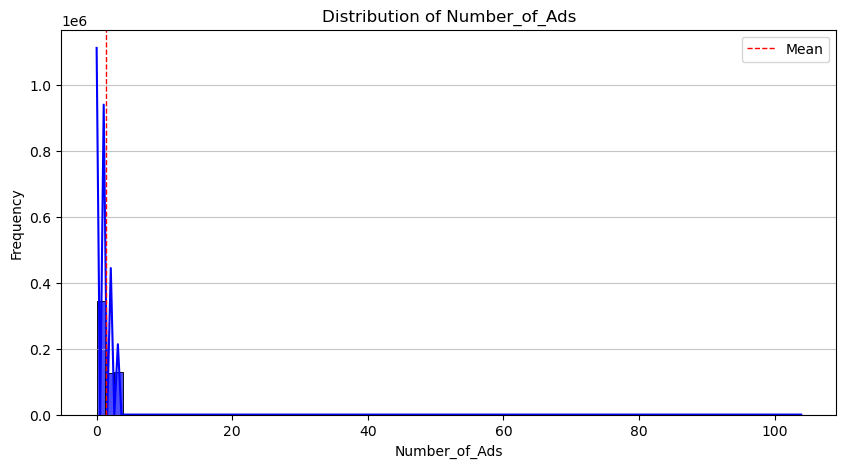

In [54]:
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('id')

# Plot distributions of numerical features
plot_features_distribution(X_train, numerical_cols)

## Test (to predict) set

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [48]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,250000.0,874999.500000,72168.927986,750000.00,812499.75,874999.50,937499.25,999999.00
Episode_Length_minutes,221264.0,419.298741,166854.502468,2.47,35.78,63.97,94.15,78486264.00
Host_Popularity_percentage,250000.0,59.716491,22.880028,2.49,39.25,59.90,79.39,117.76
Guest_Popularity_percentage,201168.0,52.192796,28.445034,0.00,28.32,53.36,76.56,116.82
Number_of_Ads,250000.0,1.355852,4.274399,0.00,0.00,1.00,2.00,2063.00


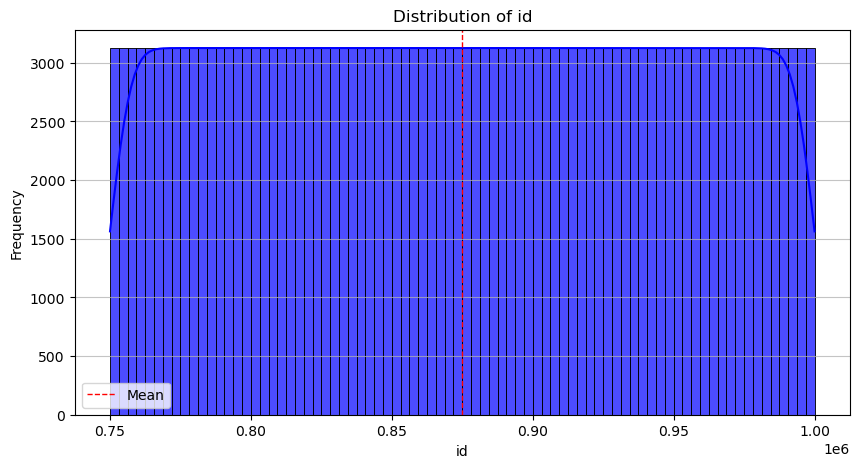

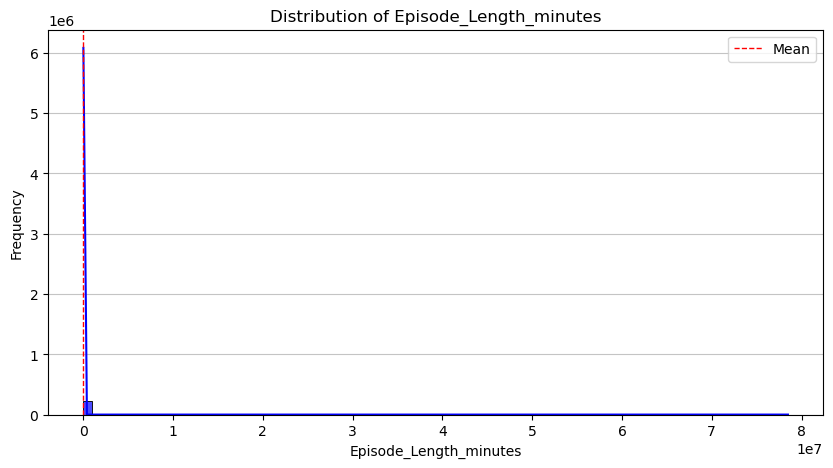

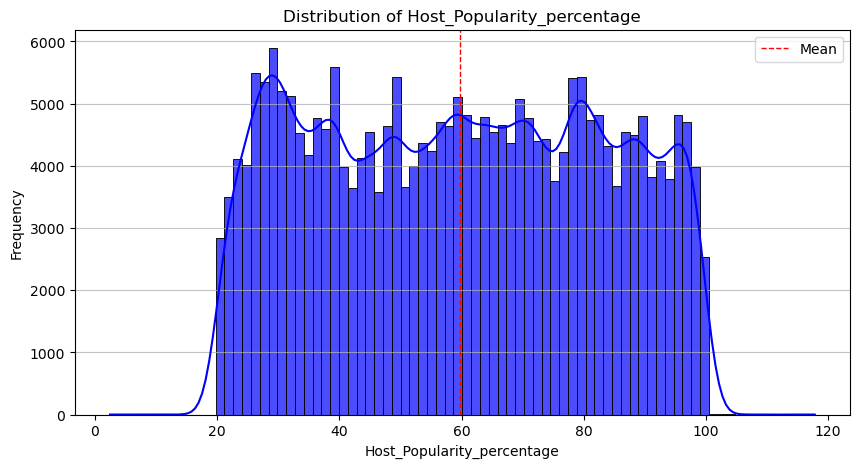

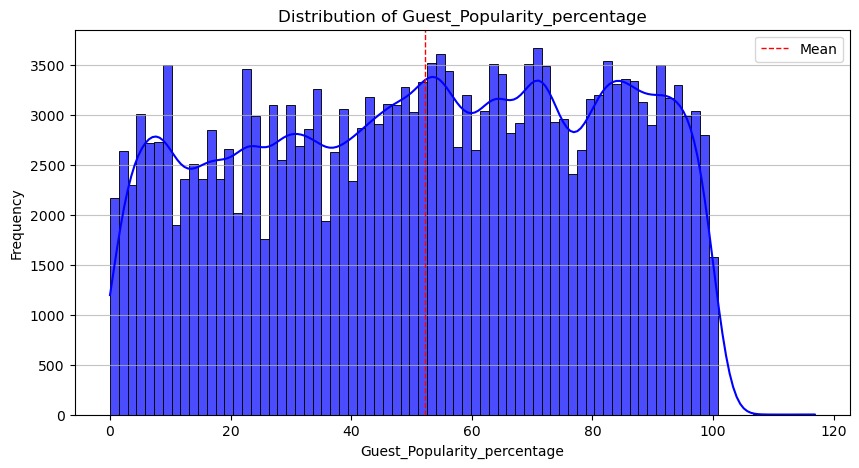

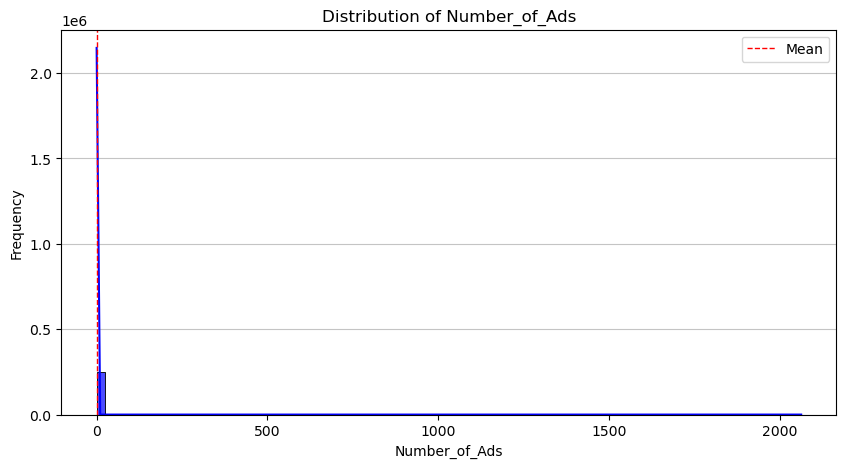

In [53]:
numerical_cols_test = test.select_dtypes(include=[np.number]).columns.tolist()

plot_features_distribution(test, numerical_cols_test)

## Insigths

### Train set

Outliers:
- Number_of_Ads

### Test set

Outlier:
- Episode_Length_minutes
- Number_of_Ads

# Preprocessing

## Feature Engineering

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [25]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,600000.0,374887.268260,216495.270700,0.0,187275.50,374830.50,562336.25,749999.00
Episode_Length_minutes,530219.0,64.532632,32.974648,0.0,35.77,63.87,94.09,120.93
Host_Popularity_percentage,600000.0,59.859155,22.870738,1.3,39.43,60.06,79.53,118.93
Guest_Popularity_percentage,483260.0,52.267251,28.446701,0.0,28.43,53.62,76.64,119.91
Number_of_Ads,599999.0,1.348430,1.161173,0.0,0.00,1.00,2.00,103.91


In [23]:
X_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
473369,473369,World Watch,Episode 41,32.29,News,62.95,Thursday,Afternoon,40.83,2.0,Positive
207987,207987,Crime Chronicles,Episode 24,111.03,True Crime,52.71,Tuesday,Morning,81.59,1.0,Negative
126595,126595,Style Guide,Episode 25,93.55,Lifestyle,67.35,Tuesday,Night,NaN,3.0,Neutral
519973,519973,Global News,Episode 92,62.74,News,92.13,Friday,Night,41.07,2.0,Negative
78405,78405,Money Matters,Episode 79,46.35,Business,39.05,Wednesday,Night,6.42,0.0,Positive


In [22]:
X_train.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')

In [158]:
def feature_eng(df, cat_ordinal_order, epsilon=1e-5):

    # Convert categorical ordinal columns from the order extracted in EDA
    for col_name, order in cat_ordinal_order.items():
        df[col_name] = df[col_name].map(order)

    

    # Get episode number from the title (Episode 37 -> 37)
    df['Episode_Number'] = df['Episode_Title'].str.extract(r'(\d+)', expand=False).astype(int)
    df.drop(columns=['Episode_Title'], inplace=True)

    # Ad density: Number of ads per minute
    df['Ad_denisty'] = df['Number_of_Ads'] / (df['Episode_Length_minutes'] + 1e-5).astype(float)  # Avoid division by zero

    # Popularity ratio: Host popularity / Guest popularity
    df['Popularity_ratio'] = df['Host_Popularity_percentage'] / (df['Guest_Popularity_percentage'] + epsilon).astype(float)  # Avoid division by zero

    # Popularity inv ratio: Guest popularity / Host popularity
    df['Popularity_inv_ratio'] = df['Guest_Popularity_percentage'] / (df['Host_Popularity_percentage'] + epsilon).astype(float)  # Avoid division by zero

    # Popularity diff: Host popularity - Guest popularity
    df['Popularity_diff'] = df['Host_Popularity_percentage'] - df['Guest_Popularity_percentage']

    # Popularity sum: Host popularity + Guest popularity
    df['Popularity_sum'] = df['Host_Popularity_percentage'] + df['Guest_Popularity_percentage']

    # Popularity interaction: Host popularity * Guest popularity
    df['Popularity_interaction'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']

    # Sentiment ratio: Episode sentiment / Host popularity
    df['Sentiment_ratio'] = df['Episode_Sentiment'] / (df['Host_Popularity_percentage'] + epsilon).astype(float)  # Avoid division by zero
    # Sentiment inv ratio: Episode sentiment / Guest popularity
    df['Sentiment_inv_ratio'] = df['Episode_Sentiment'] / (df['Guest_Popularity_percentage'] + epsilon).astype(float)  # Avoid division by zero

    # Sentiment diff: Episode sentiment - Host popularity
    df['Sentiment_diff'] = df['Episode_Sentiment'] - df['Host_Popularity_percentage']/100

    # Sentiment sum: Episode sentiment + Host popularity
    df['Sentiment_sum'] = df['Episode_Sentiment'] + df['Host_Popularity_percentage']/100

    # Sentiment interaction: Episode sentiment * Host popularity
    df['Sentiment_interaction'] = df['Episode_Sentiment'] * df['Host_Popularity_percentage']/100

    # Sentiment diff: Episode sentiment - Guest popularity
    df['Sentiment_diff_guest'] = df['Episode_Sentiment'] - df['Guest_Popularity_percentage']/100

    # Sentiment sum: Episode sentiment + Guest popularity
    df['Sentiment_sum_guest'] = df['Episode_Sentiment'] + df['Guest_Popularity_percentage']/100

    # Sentiment interaction: Episode sentiment * Guest popularity
    df['Sentiment_interaction_guest'] = df['Episode_Sentiment'] * df['Guest_Popularity_percentage']/100

    # Sentiment interaction: Episode sentiment * Number of ads
    df['Sentiment_diff_ads'] = df['Episode_Sentiment'] * df['Number_of_Ads']

    return df

In [159]:
def remove_outliers(df, col, threshold=3):
    # Remove outliers based on z-score
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    removed_ids = df[np.abs(z_scores) >= threshold]['id'].tolist()
    return df[np.abs(z_scores) < threshold], removed_ids

In [160]:
def deal_with_nans(df, cols):
    df_copy = df.copy()
    # Fill NaN values with the median of the column
    for col in cols:
        df_copy[col] = df[col].fillna(df[col].median())
        df_copy[f"NA_{col}"] = df[col].isna().astype(int)  # Create a binary column indicating if the value was NaN
    return df_copy

In [161]:
X_train_eng = feature_eng(X_train.copy(), cat_ordinal_order)
X_val_eng = feature_eng(X_val.copy(), cat_ordinal_order)
test_eng = feature_eng(test.copy(), cat_ordinal_order)

In [162]:
X_train_eng = deal_with_nans(X_train_eng, X_train_eng.columns)
X_val_eng = deal_with_nans(X_val_eng, X_val_eng.columns)
X_test_eng = deal_with_nans(test_eng, test_eng.columns)

In [163]:
X_train_clean, removed_ids_ads = remove_outliers(X_train_eng, 'Number_of_Ads')
X_val_clean, removed_ids_ads_val = remove_outliers(X_val_eng, 'Number_of_Ads')
test_clean, removed_ids_ads_test = remove_outliers(test_eng, 'Number_of_Ads')
test_clean, removed_ids_length_test = remove_outliers(test_clean, 'Episode_Length_minutes')

# Update ys accordingly
y_train_clean = y_train.loc[X_train_clean.index]
y_val_clean = y_val.loc[X_val_clean.index]

# Check dimensions
print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"y_train_clean shape: {y_train_clean.shape}")
print(f"X_val_clean shape: {X_val_clean.shape}")
print(f"y_val_clean shape: {y_val_clean.shape}")
print(f"Test original shape: {test.shape}")
print(f"Test cleaned shape: {test_clean.shape}")
print(f"Removed test ids: {len(removed_ids_ads_test) + len(removed_ids_length_test)}")
print(removed_ids_ads_test, removed_ids_length_test)

X_train_clean shape: (599991, 52)
y_train_clean shape: (599991,)
X_val_clean shape: (150000, 52)
y_val_clean shape: (150000,)
Test original shape: (250000, 11)
Test cleaned shape: (221261, 26)
Removed test ids: 3
[787939, 928393] [806597]


## Correlation

In [156]:
train_data_clean = pd.concat([X_train_clean, y_train_clean], axis=1)
val_data_clean = pd.concat([X_val_clean, y_val_clean], axis=1)

## Modeling

In [157]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error

linear_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

for name, model in linear_models.items():
    # fit the model
    model.fit(X_train_clean, y_train_clean)
    # predict on validation set
    y_pred = model.predict(X_val_clean)

    # calculate metrics
    rmse = root_mean_squared_error(y_val_clean, y_pred)
    print(f"Model: {name}, RMSE: {rmse:.4f}")

Model: LinearRegression, RMSE: 13.3148


c:\Users\rbern\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.10523e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model: Ridge, RMSE: 13.3148
Model: Lasso, RMSE: 13.3905
Model: ElasticNet, RMSE: 13.3916


## Predictiom and Submission

In [151]:
best_model = linear_models['Ridge']
best_model.fit(X_train_clean, y_train_clean)
y_test_pred = best_model.predict(test_clean)
y_test_submission = pd.DataFrame({
    'id': test_clean['id'],
    'Listening_Time_minutes': y_test_pred
})

# Add the removed ids back to the submission 
# Complete the listening time with the mean of the training set
y_test_submission = pd.concat([y_test_submission, pd.DataFrame({
    'id': removed_ids_ads_test + removed_ids_length_test,
    'Listening_Time_minutes': [y_train.mean()] * len(removed_ids_ads_test + removed_ids_length_test)
})], ignore_index=True)
y_test_submission.sort_values(by='id', inplace=True)
y_test_submission.reset_index(drop=True, inplace=True)

y_test_submission.to_csv(data_dir / 'submission.csv', index=False)
y_test_submission

,id,Listening_Time_minutes
0,750000,55.704909
1,750001,19.881448
2,750002,50.542504
3,750003,82.371135
4,750004,49.783874
...,...,...
249995,999995,9.407595
249996,999996,58.182596
249997,999997,5.605057
249998,999998,78.484495
